In [1]:
%matplotlib inline
from matplotlib import style
import matplotlib.pyplot as plt
style.use('fivethirtyeight')

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
db1 = automap_base()
# reflect the tables
db1.prepare(engine, reflect = True)

In [6]:
# View all of the classes that automap found
db1.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = db1.classes.measurement
station = db1.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)
insp = inspect(engine)

In [9]:
measurements = engine.execute('SELECT * FROM measurement LIMIT 10')
print(measurements.keys())

RMKeyView(['id', 'station', 'date', 'prcp', 'tobs'])


In [10]:
stations = engine.execute('SELECT * FROM station LIMIT 10')
print(stations.keys())

RMKeyView(['id', 'station', 'name', 'latitude', 'longitude', 'elevation'])


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
recent_date = (session.query(measurement.date)
              .order_by(measurement.date.desc())
              .first())
recent_date

('2017-08-23',)

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
past_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print('Query Date', past_year)

Query Date 2016-08-23


In [13]:
# Perform a query to retrieve the data and precipitation scores
year_rain = (session.query(measurement.date, func.avg(measurement.prcp)).
                    filter(measurement.date >= past_year).
                    group_by(measurement.date).all())
year_rain

In [14]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
rain_df = pd.DataFrame(year_rain, columns=['Date', 'Rain (In)'])
rain_df.set_index('Date', inplace=True)
rain_df.head(15)

In [15]:
# Sort the dataframe by date
rain_df.sort_values('Date')

,Rain (In)
Date,
2016-08-23,0.451667
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
...,...
2017-08-19,0.030000
2017-08-20,0.005000
2017-08-21,0.193333


<function matplotlib.pyplot.show(close=None, block=None)>

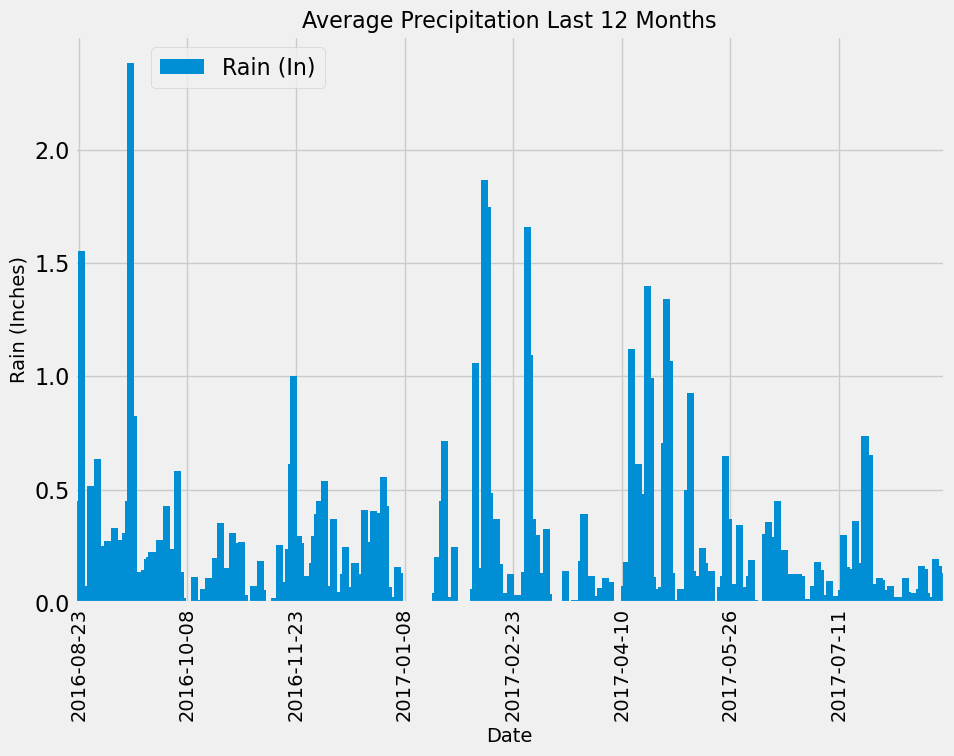

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = rain_df.plot(kind='bar', width=3, figsize=(10,7))
plt.locator_params(axis='x', nbins=8)
ax.tick_params(axis='y', labelsize=16)
ax.grid(True)
plt.legend(bbox_to_anchor=(.3,1), fontsize="16")
plt.title("Average Precipitation Last 12 Months", size=16)
plt.ylabel("Rain (Inches)", size=14)
plt.xlabel("Date", size=14)

plt.show

In [17]:
# Use Pandas to calculate the summary statistics for the precipitation data
rain_df.describe()

,Rain (In)
count,366.000000
mean,0.170757
std,0.295683
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


# Exploratory Station Analysis

In [18]:
# Design a query to calculate the total number of stations in the dataset
session.query(station.id).count()

9

In [19]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_data = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
station_data

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = station_data[0][0]
session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).filter(measurement.station == most_active).all()

[(54.0, 71.66378066378067, 85.0)]

In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
lastyear_station = session.query(measurement.station, measurement.tobs).filter(measurement.station == most_active).filter(measurement.date >= past_year).all()
lys_df = pd.DataFrame(lastyear_station)
lys_df.set_index('station', inplace=True)
lys_df.head(12)

,tobs
station,
USC00519281,77.0
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0
USC00519281,73.0
USC00519281,78.0
USC00519281,77.0
USC00519281,78.0


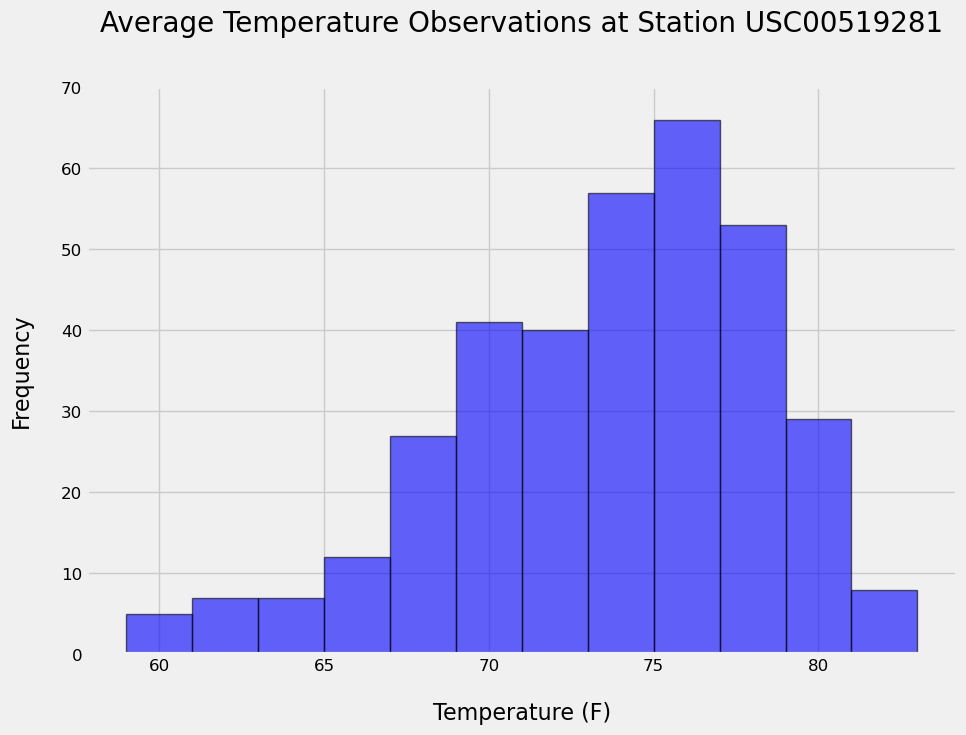

In [22]:
#plot the results as a histogram
plt.rcParams['figure.figsize']=(10,7)
plt.hist(lys_df['tobs'],bins=12,alpha=0.6,edgecolor='black',
         linewidth=1,color='blue')

plt.title('Average Temperature Observations at Station USC00519281',fontsize=20,pad=40)
plt.xlabel('Temperature (F)',fontsize=16,color='black',labelpad=20)
plt.ylabel('Frequency',fontsize=16,color='black',labelpad=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0,70)

plt.show()

# Close Session

In [90]:
# Close Session
session.close()